In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../input/sleep-research/preprocessed_data_b.csv')
data.head()

,sex,age,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control,...,Supine0 A+H+RERA_Index(h),Lateral A+H+RERA_ Index(h),REM A+H+RERA Index(/h),NREM A+H+RERA Index(/h),Apnea_Max_ Length(sec),Hypopnea_Max_ Length(sec),Resp. Arousal /(A+H)(%),ODI,90%ODI,EtCO2 (>50mmHg)
0,1,52,0,0,0,0,0,0,0,1,...,0.4,0.0,0.0,0.0,0.0,42.7,100.0,0.0,0.0,0.0
1,0,65,1,0,1,0,0,0,0,0,...,20.9,0.0,0.0,0.0,70.6,61.4,90.2,0.0,0.0,0.0
2,0,53,1,0,0,0,0,0,0,0,...,45.8,0.0,0.0,0.0,57.7,93.4,73.1,0.0,0.0,0.0
3,0,53,1,1,0,0,0,0,0,0,...,26.8,0.0,0.0,0.0,22.7,89.9,78.2,0.0,0.0,0.0
4,1,55,1,0,0,0,0,0,0,0,...,15.4,2.1,0.0,0.0,15.2,47.7,28.2,0.0,0.0,0.0


In [3]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [4]:
def cm_labels(cm):
    label_names = ['TN', 'FP', 'FN', 'TP']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{ln}\n{c}\n{p}" for ln, c, p in zip(label_names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    return labels

In [5]:
def eval_metrics(y_test, title='Confusion Matrix', pred=None, pred_proba=None, multilabel=False):
    target_names = list(y_test.columns)    
    if multilabel:
        if len(pred.shape) == 1:
            num = np.unique(y_pred, axis=0)
            num = num.shape[0]
            pred_converted = np.eye(num)[pred]
            pred = pred_converted
        
        for i, y in enumerate(y_test.columns):
            accuracy = accuracy_score(y_test[y], pred[:, i])
            print(f'{y} accuracy: {accuracy}')
        total_accuracy = accuracy_score(y_test, pred)
        print(f'total accuracy: {total_accuracy}')

        cms = multilabel_confusion_matrix(y_test, pred)
        for i, cm in enumerate(cms):
            fig, ax = plt.subplots()
            labels = cm_labels(cm)
            sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=f'{title} - {target_names[i]}')
    else:
        accuracy = accuracy_score(y_test, pred)
        print(f'accuracy: {accuracy}')
        
        cm = confusion_matrix(y_test, pred)
        labels = cm_labels(cm)
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax).set(title=title)
    
    print(classification_report(y_test, pred, target_names=target_names))
    plt.show()
    
    classification_report(y_test, pred, target_names=target_names)

In [6]:
target = data.iloc[:, 2:10]
features = data.drop(data.iloc[:, 2:10], axis=1)
target.head()

,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control
0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


### MLSMOTE
https://doi.org/10.1016/j.knosys.2015.07.019

In [7]:
from sklearn.neighbors import NearestNeighbors
import random

In [8]:
# ref: https://github.com/gnsrivastava/ec_class/blob/690433a6d296da6658aca4e4b22c4f08d5c1501a/mlsmote.py

def get_tail_label(df, q):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)  # Imbalance ratio per label: irpl
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    if q < 0:
        mir = np.average(irpl)  # Mean Imbalance ratio: mir
    else:
        mir = np.quantile(irpl, q)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df, q):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df, q)
    print(tail_labels)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label] == 1].index)
        index = index.union(sub_index)
    return list(index)


def get_minority_instace(X, y, q=-1):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y, q)
    X_sub = X[X.index.isin(index)].reset_index(drop=True)
    y_sub = y[y.index.isin(index)].reset_index(drop=True)
    return X_sub, y_sub


def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(
        n_neighbors=6, metric='euclidean', algorithm='kd_tree').fit(X)
    _, indices = nbs.kneighbors(X)
    return indices


def MLSMOTE(X, y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2) 
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)  # give number between 0 and 32
        neighbour = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis=0, skipna=True)
        target[i] = np.array([1 if val > 2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference, :] - X.loc[neighbour, :]
        new_X[i] = np.array(X.loc[reference, :] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

In [9]:
X_sub, y_sub = get_minority_instace(features, target, q=-1)
X0, y0 = MLSMOTE(X_sub, y_sub, 50)

X_sub, y_sub = get_minority_instace(features, target, q=0.75)
X1, y1 = MLSMOTE(X_sub, y_sub, 50)

X_sub, y_sub = get_minority_instace(features, target, q=0.5)
X2, y2 = MLSMOTE(X_sub, y_sub, 50)

X_sub, y_sub = get_minority_instace(features, target, q=0.25)
X3, y3 = MLSMOTE(X_sub, y_sub, 50)

['Catathrenia']
['circadian rhythm sleep-wake disorder', 'Catathrenia']
['parasomnia', 'circadian rhythm sleep-wake disorder', 'Narcolepsy, EDS, Hypersomnia', 'Catathrenia']
['insomnia', 'parasomnia', 'circadian rhythm sleep-wake disorder', 'Narcolepsy, EDS, Hypersomnia', 'Catathrenia', 'control']


In [10]:
# concatenate
X_res = pd.DataFrame(np.concatenate((features, X0, X1, X2, X3), axis=0), columns=features.columns)
y_res = pd.DataFrame(np.concatenate((target, y0, y1, y2, y3), axis=0), columns=target.columns)

In [11]:
target.describe()

,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control
count,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000
mean,0.751932,0.091829,0.112992,0.042326,0.017483,0.027420,0.001472,0.077475
std,0.431931,0.288811,0.316612,0.201351,0.131073,0.163319,0.038345,0.267368
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
y_res.describe()

,OSA,insomnia,"PLMD, RLS",parasomnia,circadian rhythm sleep-wake disorder,"Narcolepsy, EDS, Hypersomnia",Catathrenia,control
count,7591.000000,7591.000000,7591.000000,7591.000000,7591.000000,7591.000000,7591.000000,7591.000000
mean,0.600316,0.139244,0.105124,0.095640,0.057173,0.061915,0.012120,0.113292
std,0.489866,0.346224,0.306734,0.294116,0.232188,0.241018,0.109427,0.316970
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### MLSOL
ref: https://arxiv.org/pdf/1905.00609.pdf

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
y_train_converted = y_train.apply(lambda y: y.argmax(), axis=1).values

# Logistic Regression

## MultiOutputClassifier 0

In [14]:
params_dict = {
    'estimator__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    'estimator__penalty': ['l1', 'l2']
}

logreg = LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

grid_logreg0 = GridSearchCV(MultiOutputClassifier(logreg, n_jobs=4), params_dict, cv=3, refit=True)
grid_logreg0.fit(X_train, y_train)

print(grid_logreg0.best_params_)
print(grid_logreg0.best_score_)

{'estimator__C': 0.1, 'estimator__penalty': 'l1'}
0.5435723696593261


OSA accuracy: 0.8937664618086041
insomnia accuracy: 0.8784021071115014
PLMD, RLS accuracy: 0.9086918349429324
parasomnia accuracy: 0.9170324846356454
circadian rhythm sleep-wake disorder accuracy: 0.9495171202809481
Narcolepsy, EDS, Hypersomnia accuracy: 0.9473222124670764
Catathrenia accuracy: 0.9885864793678666
control accuracy: 0.9056189640035118
total accuracy: 0.5496049165935031
                                      precision    recall  f1-score   support

                                 OSA       0.92      0.89      0.91      1356
                            insomnia       0.61      0.34      0.44       317
                           PLMD, RLS       0.59      0.28      0.38       228
                          parasomnia       0.72      0.24      0.36       221
circadian rhythm sleep-wake disorder       0.47      0.12      0.20       113
        Narcolepsy, EDS, Hypersomnia       0.65      0.31      0.42       140
                         Catathrenia       0.62      0.18      0.2

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


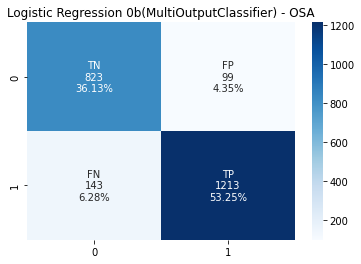

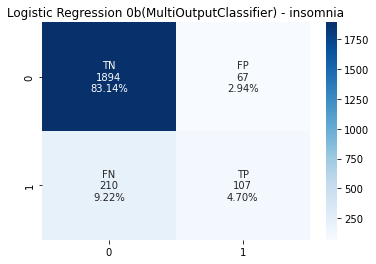

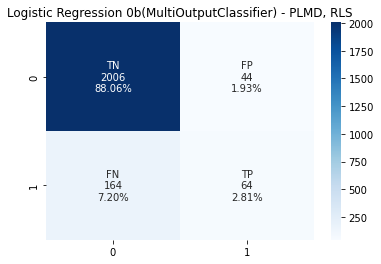

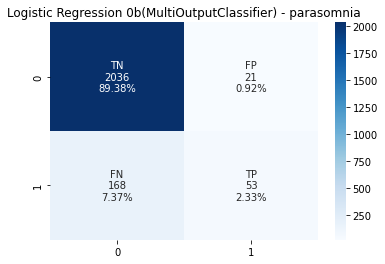

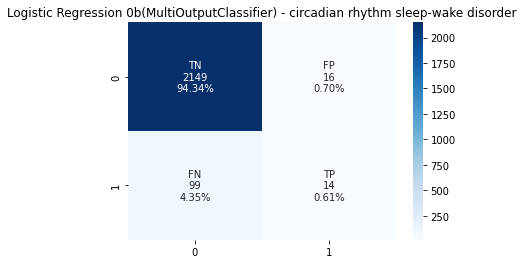

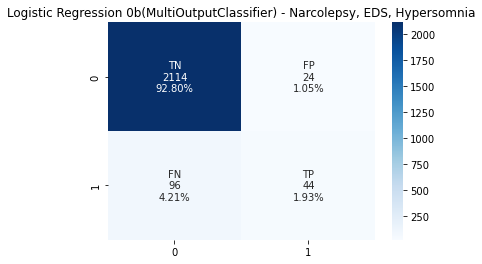

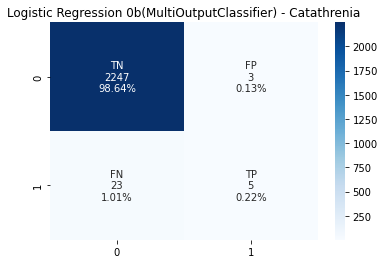

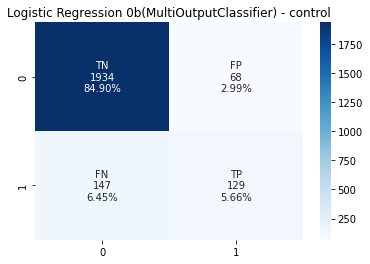

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
y_pred = grid_logreg0.best_estimator_.predict(X_test)
y_pred_proba = grid_logreg0.best_estimator_.predict_proba(X_test)

eval_metrics(y_test, title='Logistic Regression 0b(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## MultiOutputClassifier 1

In [16]:
params_dict = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2']
}

logreg = LogisticRegression(max_iter=10000, random_state=42, solver='liblinear')

grid_logreg1 = GridSearchCV(logreg, params_dict, cv=3, refit=True)
grid_logreg1.fit(X_train, y_train_converted)

print(grid_logreg1.best_params_)
print(grid_logreg1.best_score_)

multi_logreg = MultiOutputClassifier(logreg, n_jobs=4)
multi_logreg.fit(X_train, y_train)

{'C': 0.1, 'penalty': 'l1'}
0.7562582345191041


MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000,
                                                   random_state=42,
                                                   solver='liblinear'),
                      n_jobs=4)

OSA accuracy: 0.8928884986830553
insomnia accuracy: 0.8770851624231782
PLMD, RLS accuracy: 0.9091308165057067
parasomnia accuracy: 0.9165935030728709
circadian rhythm sleep-wake disorder accuracy: 0.9503950834064969
Narcolepsy, EDS, Hypersomnia accuracy: 0.9446883230904302
Catathrenia accuracy: 0.9885864793678666
control accuracy: 0.9078138718173837
total accuracy: 0.5509218612818262
                                      precision    recall  f1-score   support

                                 OSA       0.92      0.89      0.91      1356
                            insomnia       0.60      0.34      0.44       317
                           PLMD, RLS       0.60      0.28      0.38       228
                          parasomnia       0.69      0.25      0.37       221
circadian rhythm sleep-wake disorder       0.50      0.15      0.23       113
        Narcolepsy, EDS, Hypersomnia       0.59      0.34      0.43       140
                         Catathrenia       0.56      0.32      0.4

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


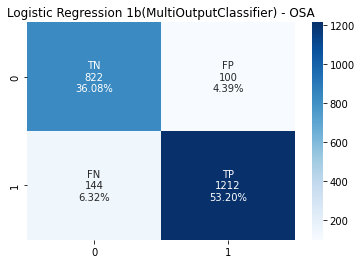

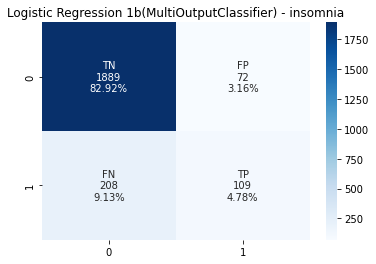

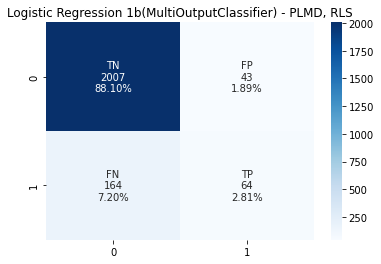

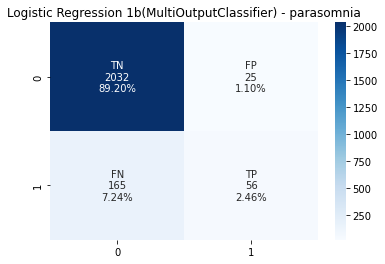

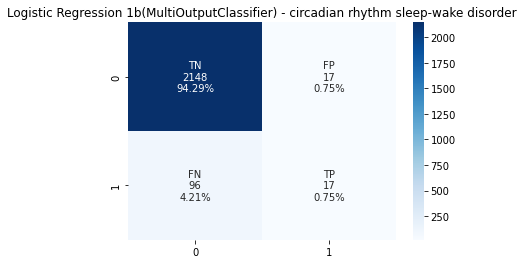

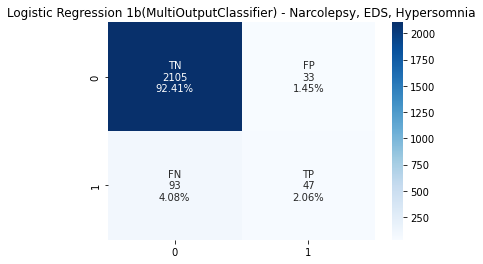

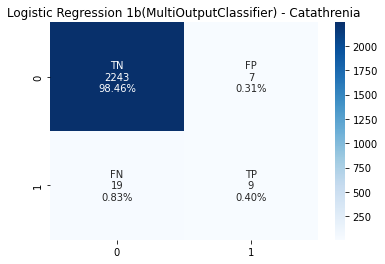

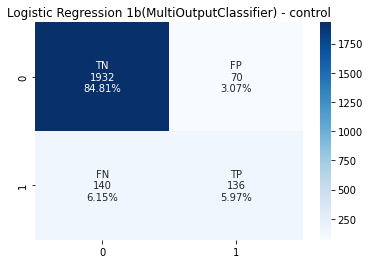

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
y_pred = multi_logreg.predict(X_test)
y_pred_proba = multi_logreg.predict_proba(X_test)

eval_metrics(y_test, title='Logistic Regression 1b(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## ClassifierChain 0

In [18]:
logreg = LogisticRegression(C=grid_logreg0.best_params_['estimator__C'], penalty=grid_logreg0.best_params_['estimator__penalty'], solver='liblinear', max_iter=10000, random_state=42)

chain_logreg0 = ClassifierChain(logreg, order='random', random_state=42)
chain_logreg0.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(C=0.1, max_iter=10000,
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                order='random', random_state=42)

OSA accuracy: 0.8933274802458296
insomnia accuracy: 0.8784021071115014
PLMD, RLS accuracy: 0.9104477611940298
parasomnia accuracy: 0.908252853380158
circadian rhythm sleep-wake disorder accuracy: 0.9411764705882353
Narcolepsy, EDS, Hypersomnia accuracy: 0.9482001755926251
Catathrenia accuracy: 0.9881474978050921
control accuracy: 0.8981562774363476
total accuracy: 0.6005267778753293
                                      precision    recall  f1-score   support

                                 OSA       0.90      0.92      0.91      1356
                            insomnia       0.61      0.34      0.44       317
                           PLMD, RLS       0.61      0.29      0.39       228
                          parasomnia       0.56      0.24      0.34       221
circadian rhythm sleep-wake disorder       0.33      0.18      0.23       113
        Narcolepsy, EDS, Hypersomnia       0.65      0.34      0.45       140
                         Catathrenia       0.57      0.14      0.23

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


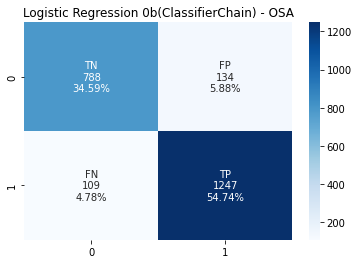

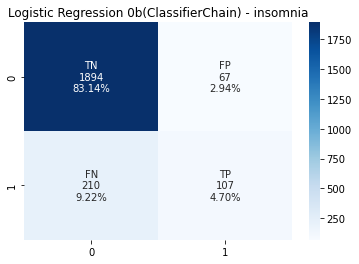

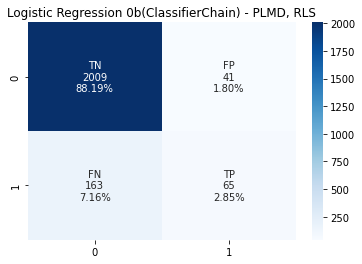

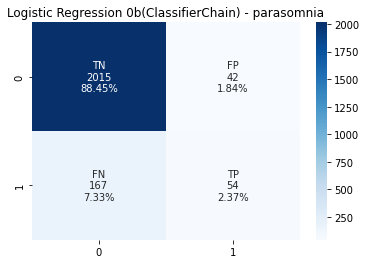

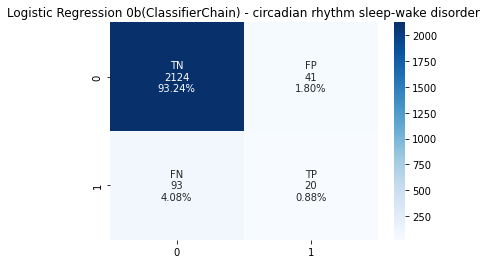

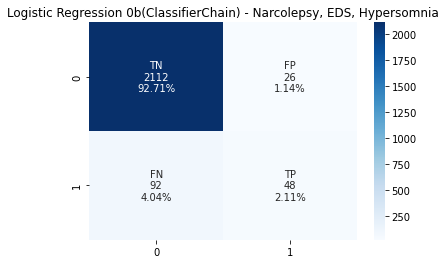

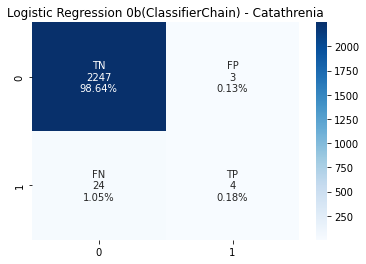

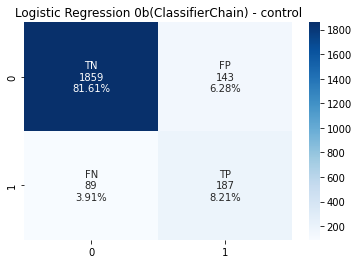

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y_pred = chain_logreg0.predict(X_test)
y_pred_proba = chain_logreg0.predict_proba(X_test)

eval_metrics(y_test, title='Logistic Regression 0b(ClassifierChain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## ClassifierChain 1

In [20]:
logreg = LogisticRegression(C=grid_logreg1.best_params_['C'], penalty=grid_logreg1.best_params_['penalty'], solver='liblinear', max_iter=10000, random_state=42)

chain_logreg1 = ClassifierChain(logreg, order='random', random_state=42)
chain_logreg1.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(C=0.1, max_iter=10000,
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                order='random', random_state=42)

OSA accuracy: 0.8933274802458296
insomnia accuracy: 0.8784021071115014
PLMD, RLS accuracy: 0.9104477611940298
parasomnia accuracy: 0.908252853380158
circadian rhythm sleep-wake disorder accuracy: 0.9411764705882353
Narcolepsy, EDS, Hypersomnia accuracy: 0.9482001755926251
Catathrenia accuracy: 0.9881474978050921
control accuracy: 0.8981562774363476
total accuracy: 0.6005267778753293
                                      precision    recall  f1-score   support

                                 OSA       0.90      0.92      0.91      1356
                            insomnia       0.61      0.34      0.44       317
                           PLMD, RLS       0.61      0.29      0.39       228
                          parasomnia       0.56      0.24      0.34       221
circadian rhythm sleep-wake disorder       0.33      0.18      0.23       113
        Narcolepsy, EDS, Hypersomnia       0.65      0.34      0.45       140
                         Catathrenia       0.57      0.14      0.23

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


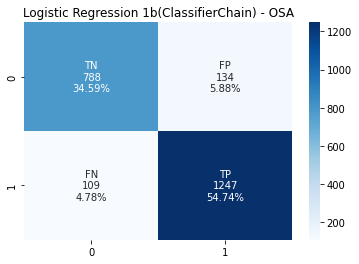

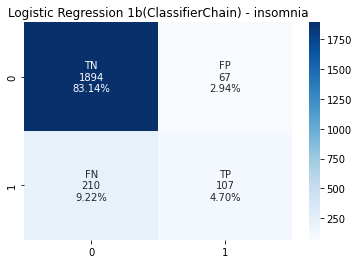

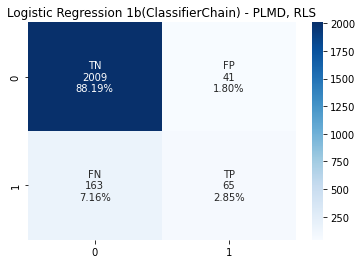

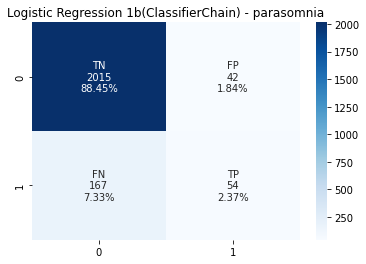

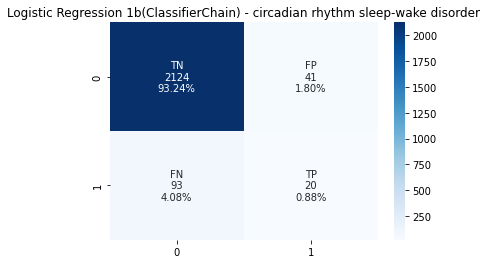

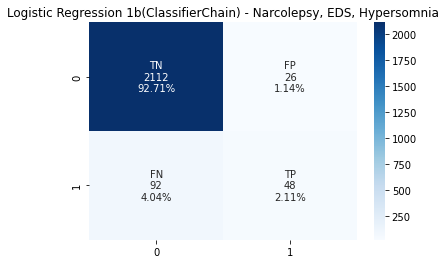

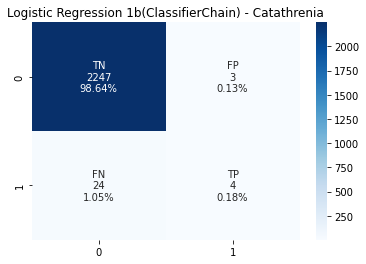

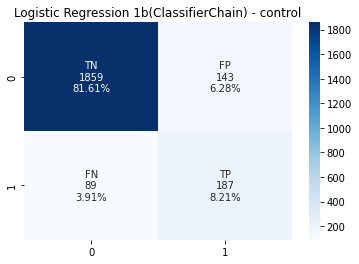

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
y_pred = chain_logreg1.predict(X_test)
y_pred_proba = chain_logreg1.predict_proba(X_test)

eval_metrics(y_test, title='Logistic Regression 1b(ClassifierChain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

# SVM

## MultiOutputClassifier 0

In [22]:
params_dict = {
    'estimator__C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'estimator__gamma': [0.001, 0.01, 0.1, 1.0, 10.0]
}

svc = SVC(probability=True, random_state=42)

grid_svc0 = GridSearchCV(MultiOutputClassifier(svc, n_jobs=4), params_dict, cv=3, refit=True)
grid_svc0.fit(X_train, y_train)

print(grid_svc0.best_params_)
print(grid_svc0.best_score_)

{'estimator__C': 10.0, 'estimator__gamma': 0.001}
0.745906267645398


OSA accuracy: 0.8959613696224759
insomnia accuracy: 0.9697102721685689
PLMD, RLS accuracy: 0.9284460052677788
parasomnia accuracy: 0.9833187006145742
circadian rhythm sleep-wake disorder accuracy: 0.9964881474978051
Narcolepsy, EDS, Hypersomnia accuracy: 0.9947322212467077
Catathrenia accuracy: 0.995171202809482
control accuracy: 0.9534679543459175
total accuracy: 0.8296751536435469
                                      precision    recall  f1-score   support

                                 OSA       0.85      1.00      0.92      1356
                            insomnia       1.00      0.79      0.88       317
                           PLMD, RLS       0.96      0.30      0.45       228
                          parasomnia       0.99      0.83      0.91       221
circadian rhythm sleep-wake disorder       0.98      0.95      0.96       113
        Narcolepsy, EDS, Hypersomnia       0.99      0.92      0.96       140
                         Catathrenia       0.95      0.64      0.77

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


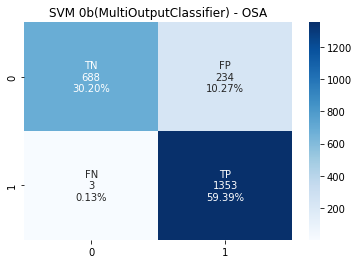

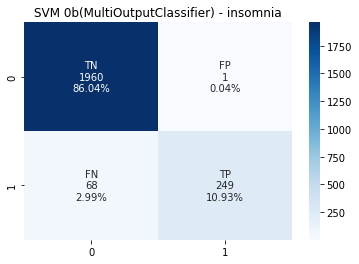

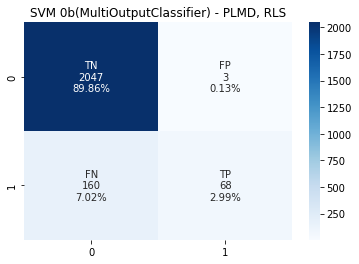

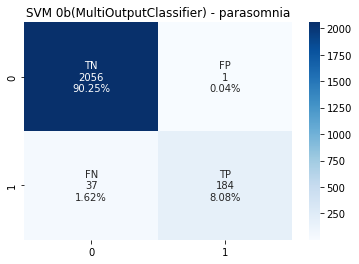

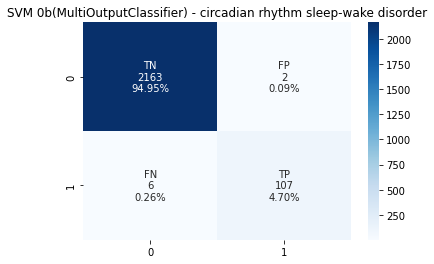

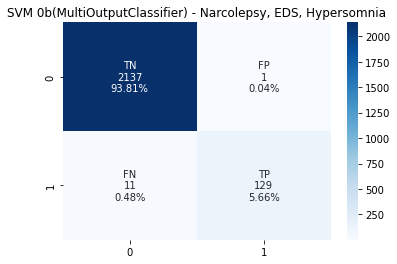

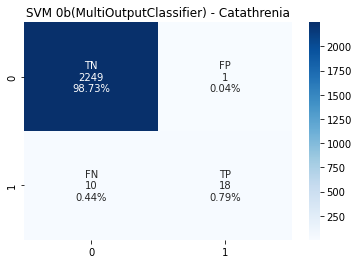

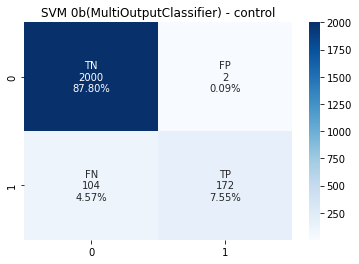

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
y_pred = grid_svc0.best_estimator_.predict(X_test)
y_pred_proba = grid_svc0.best_estimator_.predict_proba(X_test)

eval_metrics(y_test, title='SVM 0b(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## MultiOutputClassifier 1

In [24]:
params_dict = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'gamma': [0.001, 0.01, 0.1, 1.0, 10.0]
}

svc = SVC(probability=True, random_state=42)

grid_svc1 = GridSearchCV(svc, params_dict, cv=3, refit=True)
grid_svc1.fit(X_train, y_train_converted)

print(grid_svc1.best_params_)
print(grid_svc1.best_score_)

multi_svc = MultiOutputClassifier(grid_svc1.best_estimator_, n_jobs=4)
multi_svc.fit(X_train, y_train)

{'C': 10.0, 'gamma': 0.001}
0.818746470920384


MultiOutputClassifier(estimator=SVC(C=10.0, gamma=0.001, probability=True,
                                    random_state=42),
                      n_jobs=4)

OSA accuracy: 0.8959613696224759
insomnia accuracy: 0.9697102721685689
PLMD, RLS accuracy: 0.9284460052677788
parasomnia accuracy: 0.9833187006145742
circadian rhythm sleep-wake disorder accuracy: 0.9964881474978051
Narcolepsy, EDS, Hypersomnia accuracy: 0.9947322212467077
Catathrenia accuracy: 0.995171202809482
control accuracy: 0.9534679543459175
total accuracy: 0.8296751536435469
                                      precision    recall  f1-score   support

                                 OSA       0.85      1.00      0.92      1356
                            insomnia       1.00      0.79      0.88       317
                           PLMD, RLS       0.96      0.30      0.45       228
                          parasomnia       0.99      0.83      0.91       221
circadian rhythm sleep-wake disorder       0.98      0.95      0.96       113
        Narcolepsy, EDS, Hypersomnia       0.99      0.92      0.96       140
                         Catathrenia       0.95      0.64      0.77

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


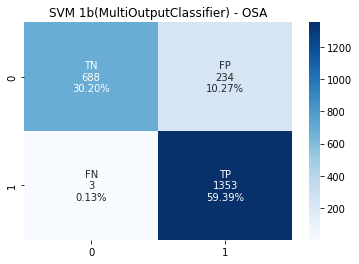

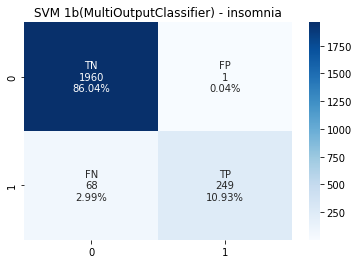

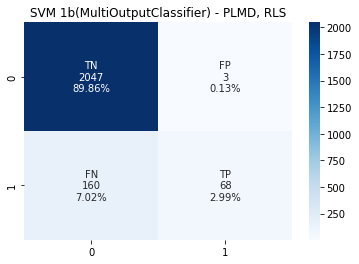

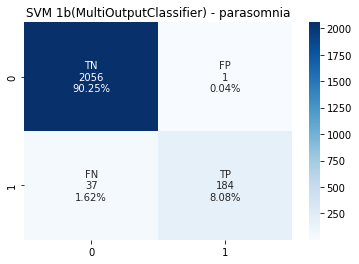

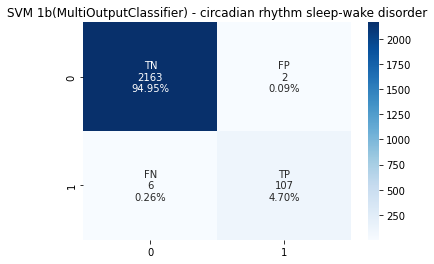

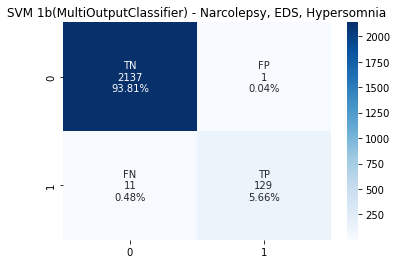

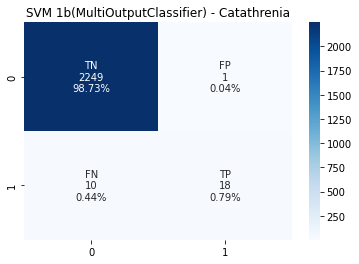

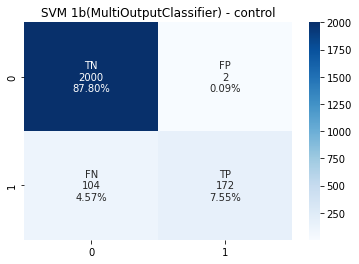

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
y_pred = multi_svc.predict(X_test)
y_pred_proba = multi_svc.predict_proba(X_test)

eval_metrics(y_test, title='SVM 1b(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## ClassifierChain 0

In [26]:
svc = SVC(probability=True, random_state=42, C=grid_svc0.best_params_['estimator__C'], gamma=grid_svc0.best_params_['estimator__gamma'])

chain_svc0 = ClassifierChain(svc, order='random', random_state=42)
chain_svc0.fit(X_train, y_train)

ClassifierChain(base_estimator=SVC(C=10.0, gamma=0.001, probability=True,
                                   random_state=42),
                order='random', random_state=42)

OSA accuracy: 0.8959613696224759
insomnia accuracy: 0.9697102721685689
PLMD, RLS accuracy: 0.9284460052677788
parasomnia accuracy: 0.9833187006145742
circadian rhythm sleep-wake disorder accuracy: 0.9964881474978051
Narcolepsy, EDS, Hypersomnia accuracy: 0.9947322212467077
Catathrenia accuracy: 0.995171202809482
control accuracy: 0.9534679543459175
total accuracy: 0.8296751536435469
                                      precision    recall  f1-score   support

                                 OSA       0.85      1.00      0.92      1356
                            insomnia       1.00      0.79      0.88       317
                           PLMD, RLS       0.96      0.30      0.45       228
                          parasomnia       0.99      0.83      0.91       221
circadian rhythm sleep-wake disorder       0.98      0.95      0.96       113
        Narcolepsy, EDS, Hypersomnia       0.99      0.92      0.96       140
                         Catathrenia       0.95      0.64      0.77

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


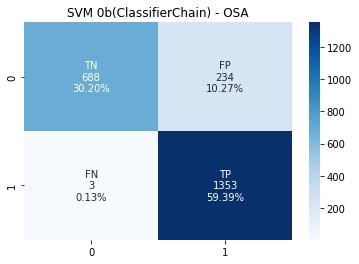

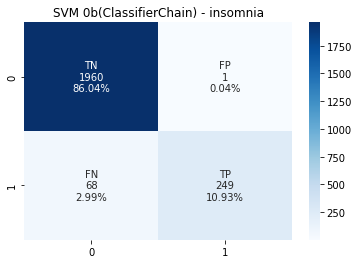

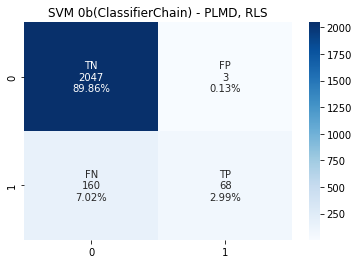

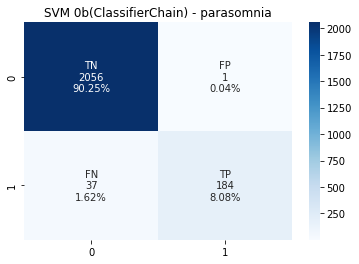

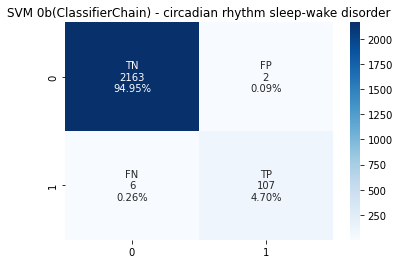

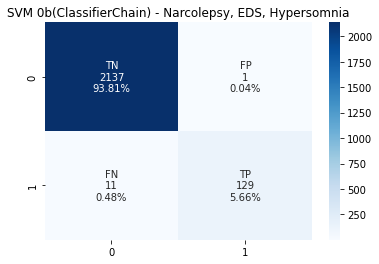

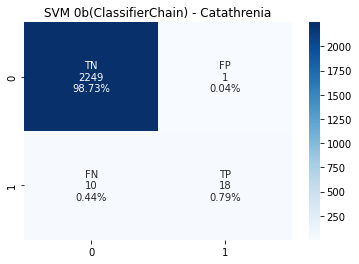

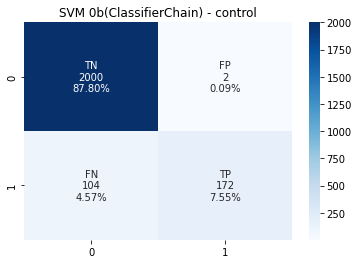

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
y_pred = chain_svc0.predict(X_test)
y_pred_proba = chain_svc0.predict_proba(X_test)

eval_metrics(y_test, title='SVM 0b(ClassifierChain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## ClassifierChain 1

In [28]:
svc = SVC(probability=True, random_state=42, C=grid_svc1.best_params_['C'], gamma=grid_svc1.best_params_['gamma'])

chain_svc1 = ClassifierChain(svc, order='random', random_state=42)
chain_svc1.fit(X_train, y_train)

ClassifierChain(base_estimator=SVC(C=10.0, gamma=0.001, probability=True,
                                   random_state=42),
                order='random', random_state=42)

OSA accuracy: 0.8959613696224759
insomnia accuracy: 0.9697102721685689
PLMD, RLS accuracy: 0.9284460052677788
parasomnia accuracy: 0.9833187006145742
circadian rhythm sleep-wake disorder accuracy: 0.9964881474978051
Narcolepsy, EDS, Hypersomnia accuracy: 0.9947322212467077
Catathrenia accuracy: 0.995171202809482
control accuracy: 0.9534679543459175
total accuracy: 0.8296751536435469
                                      precision    recall  f1-score   support

                                 OSA       0.85      1.00      0.92      1356
                            insomnia       1.00      0.79      0.88       317
                           PLMD, RLS       0.96      0.30      0.45       228
                          parasomnia       0.99      0.83      0.91       221
circadian rhythm sleep-wake disorder       0.98      0.95      0.96       113
        Narcolepsy, EDS, Hypersomnia       0.99      0.92      0.96       140
                         Catathrenia       0.95      0.64      0.77

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


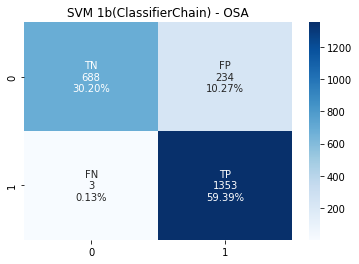

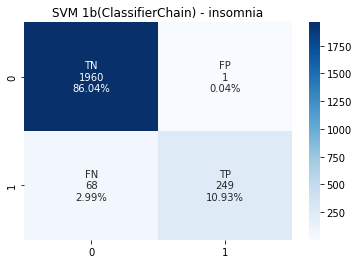

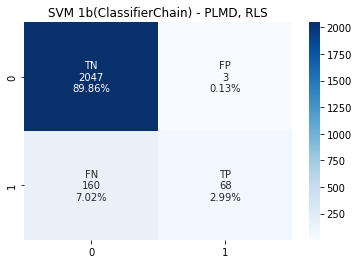

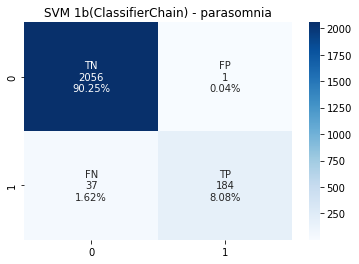

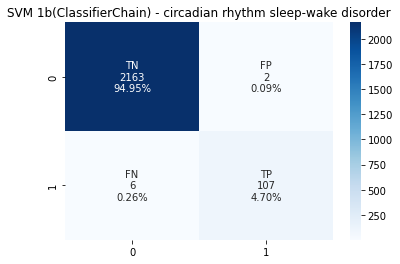

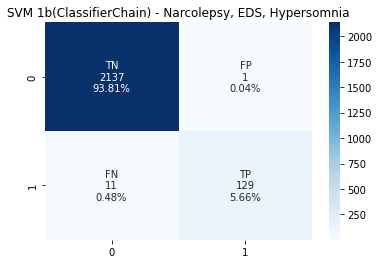

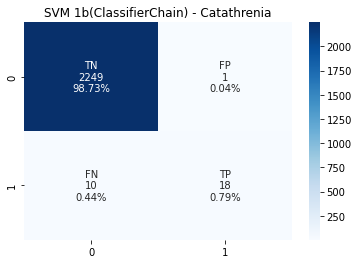

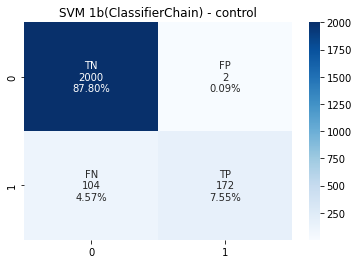

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
y_pred = chain_svc1.predict(X_test)
y_pred_proba = chain_svc1.predict_proba(X_test)

eval_metrics(y_test, title='SVM 1b(ClassifierChain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

# Random Forest

## MultiOutputClassifier 0

In [30]:
params_dict = {
    'estimator__n_estimators': [10, 50, 100],
    'estimator__max_depth': [2, 4, 6, 8, 10, 12],
    'estimator__min_samples_leaf': [2, 4, 6, 8, 12, 18],
    'estimator__min_samples_split': [2, 4, 6, 8, 16, 20]
}

forest = RandomForestClassifier(random_state=42)

grid_forest0 = GridSearchCV(MultiOutputClassifier(forest, n_jobs=4), params_dict, cv=3, refit=True)
grid_forest0.fit(X_train, y_train)

print(grid_forest0.best_params_)
print(grid_forest0.best_score_)

{'estimator__max_depth': 12, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
0.6975343497082628


OSA accuracy: 0.9455662862159789
insomnia accuracy: 0.9486391571553995
PLMD, RLS accuracy: 0.9280070237050044
parasomnia accuracy: 0.9578577699736611
circadian rhythm sleep-wake disorder accuracy: 0.9824407374890255
Narcolepsy, EDS, Hypersomnia accuracy: 0.9863915715539947
Catathrenia accuracy: 0.995171202809482
control accuracy: 0.9622475856014048
total accuracy: 0.7633889376646181
                                      precision    recall  f1-score   support

                                 OSA       0.96      0.95      0.95      1356
                            insomnia       0.93      0.68      0.79       317
                           PLMD, RLS       0.84      0.35      0.49       228
                          parasomnia       0.98      0.58      0.73       221
circadian rhythm sleep-wake disorder       1.00      0.65      0.78       113
        Narcolepsy, EDS, Hypersomnia       0.95      0.82      0.88       140
                         Catathrenia       1.00      0.61      0.76

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


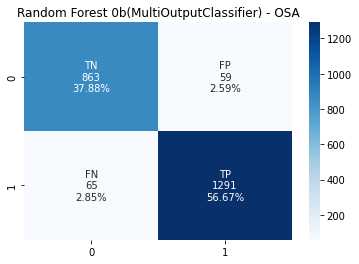

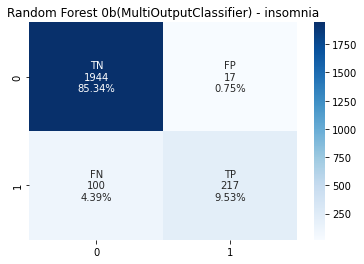

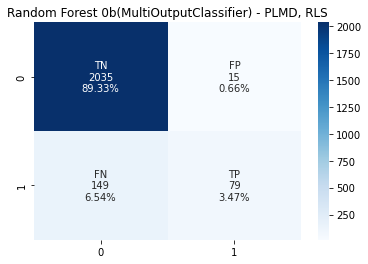

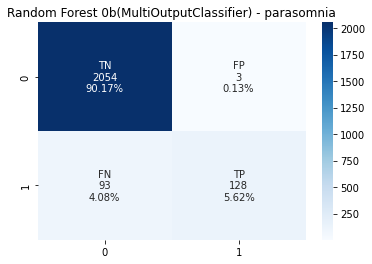

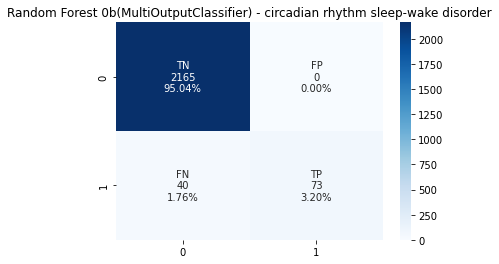

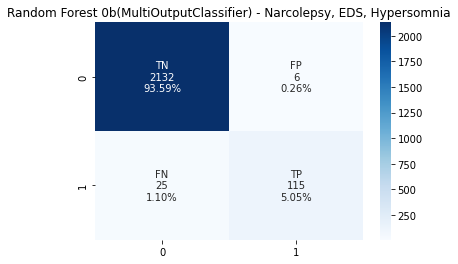

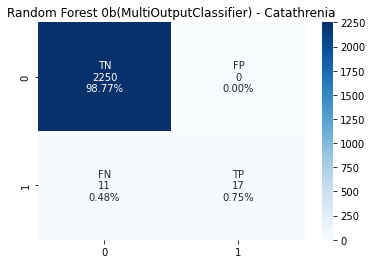

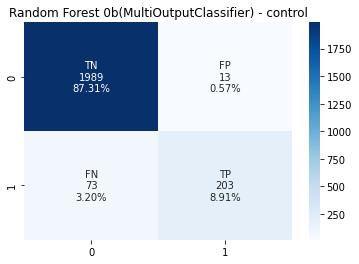

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
y_pred = grid_forest0.best_estimator_.predict(X_test)
y_pred_proba = grid_forest0.best_estimator_.predict_proba(X_test)

eval_metrics(y_test, title='Random Forest 0b(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## MultiOutputClassifier 1

In [32]:
params_dict = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 4, 6, 8, 10, 12],
    'min_samples_leaf': [2, 4, 6, 8, 12, 18],
    'min_samples_split': [2, 4, 6, 8, 16, 20]
}

forest = RandomForestClassifier(random_state=42)

grid_forest1 = GridSearchCV(forest, params_dict, cv=3, refit=True)
grid_forest1.fit(X_train, y_train_converted)

print(grid_forest1.best_params_)
print(grid_forest1.best_score_)

multi_forest = MultiOutputClassifier(grid_forest1.best_estimator_, n_jobs=4)
multi_forest.fit(X_train, y_train)

{'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.8586485977790326


MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=12,
                                                       min_samples_leaf=2,
                                                       random_state=42),
                      n_jobs=4)

OSA accuracy: 0.9455662862159789
insomnia accuracy: 0.9486391571553995
PLMD, RLS accuracy: 0.9280070237050044
parasomnia accuracy: 0.9578577699736611
circadian rhythm sleep-wake disorder accuracy: 0.9824407374890255
Narcolepsy, EDS, Hypersomnia accuracy: 0.9863915715539947
Catathrenia accuracy: 0.995171202809482
control accuracy: 0.9622475856014048
total accuracy: 0.7633889376646181
                                      precision    recall  f1-score   support

                                 OSA       0.96      0.95      0.95      1356
                            insomnia       0.93      0.68      0.79       317
                           PLMD, RLS       0.84      0.35      0.49       228
                          parasomnia       0.98      0.58      0.73       221
circadian rhythm sleep-wake disorder       1.00      0.65      0.78       113
        Narcolepsy, EDS, Hypersomnia       0.95      0.82      0.88       140
                         Catathrenia       1.00      0.61      0.76

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


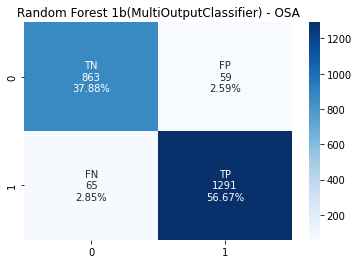

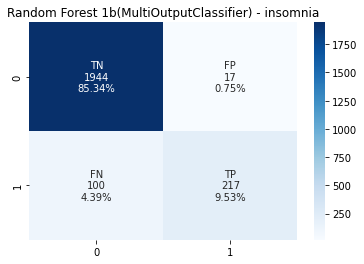

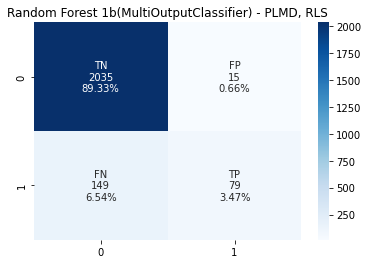

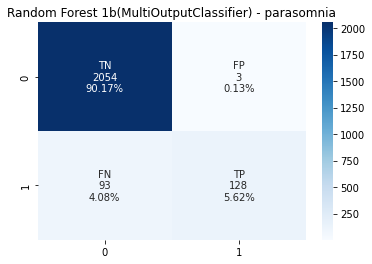

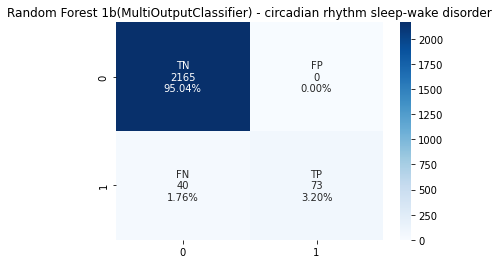

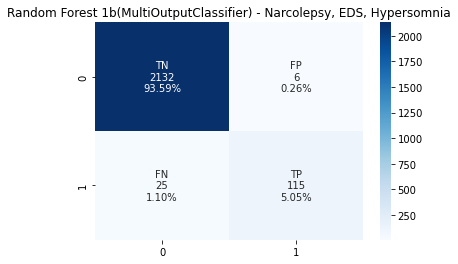

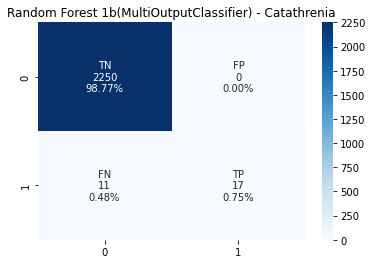

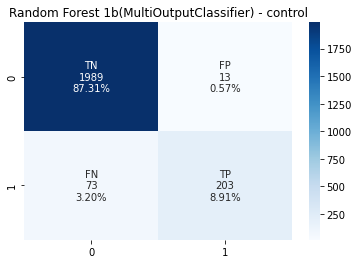

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
y_pred = multi_forest.predict(X_test)
y_pred_proba = multi_forest.predict_proba(X_test)

eval_metrics(y_test, title='Random Forest 1b(MultiOutputClassifier)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## ClassifierChain 0

In [34]:
forest = RandomForestClassifier(
    n_estimators=grid_forest0.best_params_['estimator__n_estimators'],
    max_depth=grid_forest0.best_params_['estimator__max_depth'],
    min_samples_leaf=grid_forest0.best_params_['estimator__min_samples_leaf'],
    min_samples_split=grid_forest0.best_params_['estimator__min_samples_split'],
    random_state=42
)

chain_forest0 = ClassifierChain(forest, order='random', random_state=42)
chain_forest0.fit(X_train, y_train)

ClassifierChain(base_estimator=RandomForestClassifier(max_depth=12,
                                                      min_samples_leaf=2,
                                                      random_state=42),
                order='random', random_state=42)

OSA accuracy: 0.9429323968393327
insomnia accuracy: 0.9486391571553995
PLMD, RLS accuracy: 0.92756804214223
parasomnia accuracy: 0.9591747146619842
circadian rhythm sleep-wake disorder accuracy: 0.9824407374890255
Narcolepsy, EDS, Hypersomnia accuracy: 0.9859525899912204
Catathrenia accuracy: 0.9956101843722563
control accuracy: 0.966198419666374
total accuracy: 0.7835820895522388
                                      precision    recall  f1-score   support

                                 OSA       0.94      0.96      0.95      1356
                            insomnia       0.93      0.68      0.79       317
                           PLMD, RLS       0.82      0.35      0.49       228
                          parasomnia       0.98      0.59      0.74       221
circadian rhythm sleep-wake disorder       1.00      0.65      0.78       113
        Narcolepsy, EDS, Hypersomnia       0.97      0.79      0.87       140
                         Catathrenia       1.00      0.64      0.78  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


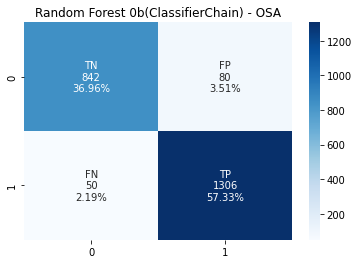

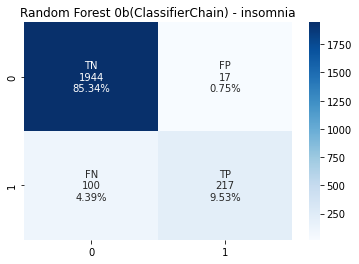

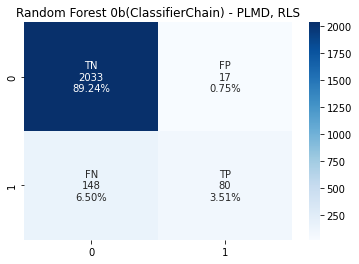

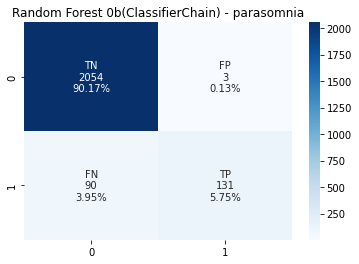

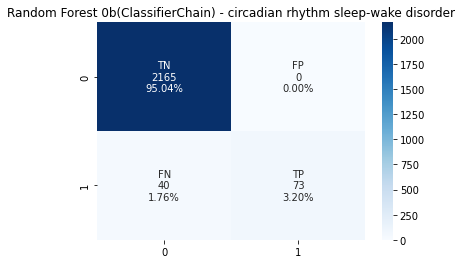

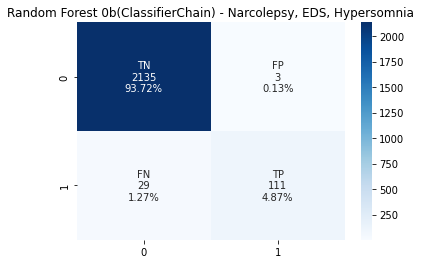

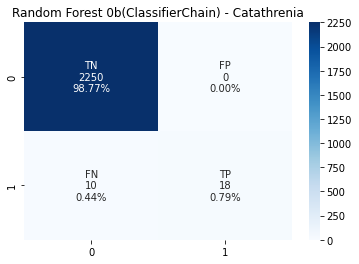

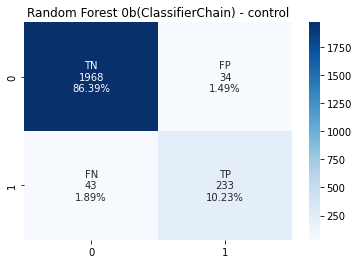

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
y_pred = chain_forest0.predict(X_test)
y_pred_proba = chain_forest0.predict_proba(X_test)

eval_metrics(y_test, title='Random Forest 0b(ClassifierChain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)

## ClassifierChain 1

In [36]:
forest = RandomForestClassifier(
    n_estimators=grid_forest1.best_params_['n_estimators'],
    max_depth=grid_forest1.best_params_['max_depth'],
    min_samples_leaf=grid_forest1.best_params_['min_samples_leaf'],
    min_samples_split=grid_forest1.best_params_['min_samples_split'],
    random_state=42
)

chain_forest1 = ClassifierChain(forest, order='random', random_state=42)
chain_forest1.fit(X_train, y_train)

ClassifierChain(base_estimator=RandomForestClassifier(max_depth=12,
                                                      min_samples_leaf=2,
                                                      random_state=42),
                order='random', random_state=42)

OSA accuracy: 0.9429323968393327
insomnia accuracy: 0.9486391571553995
PLMD, RLS accuracy: 0.92756804214223
parasomnia accuracy: 0.9591747146619842
circadian rhythm sleep-wake disorder accuracy: 0.9824407374890255
Narcolepsy, EDS, Hypersomnia accuracy: 0.9859525899912204
Catathrenia accuracy: 0.9956101843722563
control accuracy: 0.966198419666374
total accuracy: 0.7835820895522388
                                      precision    recall  f1-score   support

                                 OSA       0.94      0.96      0.95      1356
                            insomnia       0.93      0.68      0.79       317
                           PLMD, RLS       0.82      0.35      0.49       228
                          parasomnia       0.98      0.59      0.74       221
circadian rhythm sleep-wake disorder       1.00      0.65      0.78       113
        Narcolepsy, EDS, Hypersomnia       0.97      0.79      0.87       140
                         Catathrenia       1.00      0.64      0.78  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


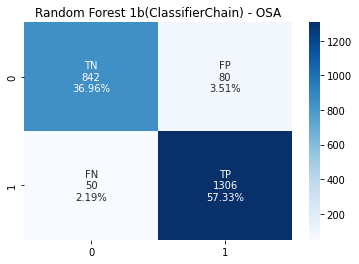

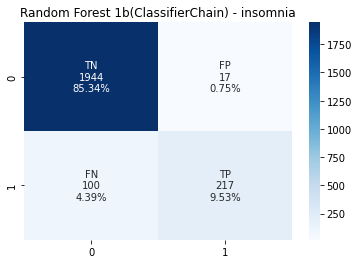

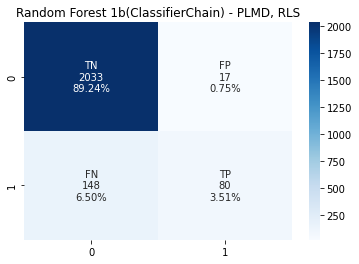

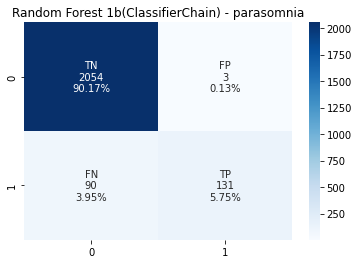

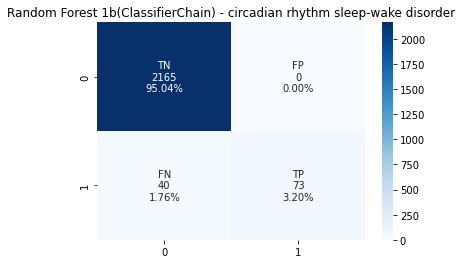

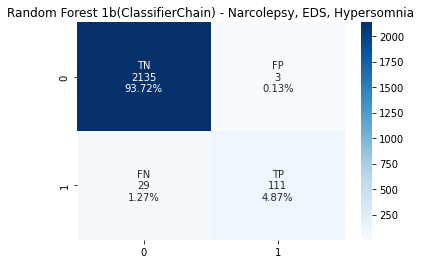

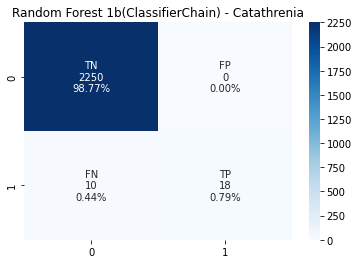

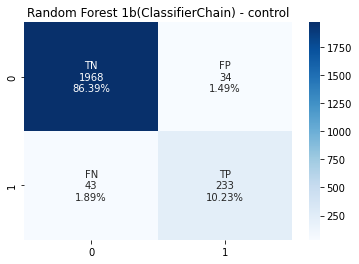

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
y_pred = chain_forest1.predict(X_test)
y_pred_proba = chain_forest1.predict_proba(X_test)

eval_metrics(y_test, title='Random Forest 1b(ClassifierChain)', pred=y_pred, pred_proba=y_pred_proba, multilabel=True)